In [ ]:
"""
José Javier Calvo Moratilla
MUIARFID 2021-2022
VPC
Eye vain segmentation
.
Dataset: 
"""
#################################################################
# Imports
#################################################################
import numpy as np
from PIL import Image
import tensorflow as tf

from keras.layers import Activation, Conv2D, MaxPooling2D,UpSampling2D, Input, Concatenate
from keras.layers import BatchNormalization as BN

from keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from keras.models import Model

1# import the cv2 library2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from IPython.display import display
from keras.utils.vis_utils import plot_model

from keras.preprocessing.image import ImageDataGenerator

import albumentations as A

In [ ]:
#################################################################
# Parameters and load images
#################################################################

!wget https://www.dropbox.com/s/qii26wuxcbxw169/images.npy
!wget https://www.dropbox.com/s/gstpamhin8rlhlg/masks.npy

images=np.load("images.npy")
print(images.shape)
## Crop 512
images=images[:,0:512,0:512,:]

#im=Image.fromarray(images[0])
#im.show()

masks=np.load("masks.npy")
print(masks.shape)
## Crop 512
masks=masks[:,0:512,0:512]

#im=Image.fromarray(masks[0])
#im.show()

#Normalization
images=images/np.max(images)
masks=masks/np.max(masks)

print(np.min(masks[0]),np.max(masks[0]))

input_folder = "drive/MyDrive/MUIARFID/VPC/Eyes/"



--2022-05-31 20:00:47--  https://www.dropbox.com/s/qii26wuxcbxw169/images.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qii26wuxcbxw169/images.npy [following]
--2022-05-31 20:00:47--  https://www.dropbox.com/s/raw/qii26wuxcbxw169/images.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3f11b1f1efa6eba5517f0d12f1.dl.dropboxusercontent.com/cd/0/inline/BmV6XhgE9G0lmF7zs8L5IjVVnTbxITK1WtW76Zew7TDn2sU0I0p8fh0vHXknR8-BXtPI0jQAnZFW60RNJrvKnPTAkLblr2feOOWsmbAefN1_DxzhtN3aCTDPwP_OhOeq2-73R6_uC6Is1BmEjOr_98OfvILLAoVsdvuGsJYhm_yV2g/file# [following]
--2022-05-31 20:00:47--  https://uc3f11b1f1efa6eba5517f0d12f1.dl.dropboxusercontent.com/cd/0/inline/BmV6XhgE9G0lmF7zs8L5IjVVnTbxITK1WtW76Zew7TDn2sU0I0p8fh0vHXknR8-BXtPI0jQAnZ

In [ ]:
#################################################################
# Build Data Augmentation
#################################################################
def Augmentor (img):

    transform = A.Compose([
        #A.HorizontalFlip(p=0.5), #1
        #A.ShiftScaleRotate(p=1.0, shift_limit=(-0.05, 0.05), scale_limit=(-0.05, 0.05), rotate_limit=(-10, 10), border_mode=4), #
        #nuevos       
        A.RandomBrightnessContrast(p=0.2),
        #A.ChannelDropout()
    ])
    
    img = 255 * img
    img = img.astype(np.uint8)

    transformed = transform(image=img)
    transformed_img = transformed["image"]
      
    transformed_img = transformed_img.astype('float32')
    transformed_img /= 255
    
    return transformed_img


datagen = ImageDataGenerator(preprocessing_function = Augmentor)
datagen.fit(images)    
'''
# load and iterate training dataset
train_it = train_datagen.flow_from_directory("drive/MyDrive/MUIARFID/VPC/Eyes/data/train/", target_size=(256, 256),
    color_mode="rgb",
    batch_size=2,
    class_mode="input",
    shuffle=True,
    seed=0)
'''


'\n# load and iterate training dataset\ntrain_it = train_datagen.flow_from_directory("drive/MyDrive/MUIARFID/VPC/Eyes/data/train/", target_size=(256, 256),\n    color_mode="rgb",\n    batch_size=2,\n    class_mode="input",\n    shuffle=True,\n    seed=0)\n'

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_144 (Conv2D)            (None, 512, 512, 32  896         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_108 (Batch  (None, 512, 512, 32  128        ['conv2d_144[0][0]']             
 Normalization)                 )                                                           

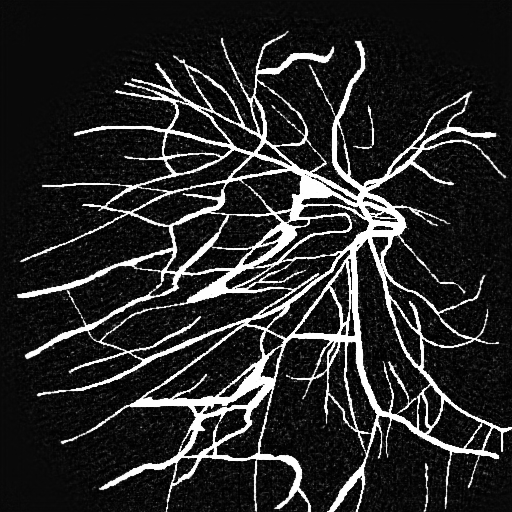

In [ ]:
#################################################################
# Build the model
#################################################################

def EncBlock(layer,num,filters):
	l=layer
	for i in range(num):
		l=Conv2D(filters, (3, 3), padding='same')(l)
		l=BN()(l)
		l=Activation('relu')(l)

	l=MaxPooling2D((2,2))(l)
	
	return l


def DecBlock(layer,num,filters,enclayer=None):
	l=layer

	for i in range(num):
		l=Conv2D(filters, (3, 3), padding='same')(l)
		l=BN()(l)
		l=Activation('relu')(l)

	l=UpSampling2D((2,2))(layer)
	l=Conv2D(filters, (3, 3), padding='same')(l)
	l=BN()(l)
	return l

def ConcatBlock(layer, num, filters):
	l=layer

	for i in range(num):
		l=Conv2D(filters, (1, 1), padding='same')(l)
		l=Activation('relu')(l)
		l=Conv2D(filters, (1, 1), padding='same')(l)
		l=Activation('relu')(l)
	
	l=UpSampling2D((2,2))(layer)
	return l

def EncDec(x0):

	## End	
	x1=EncBlock(x0,2,32) # 256
	x2=EncBlock(x1,2,64) #128
	x21 = ConcatBlock(x1, 1, 128)

	x3=EncBlock(x2,2,128) # 64
	x31 = ConcatBlock(x3, 1, 64)

	x4=EncBlock(x3,2,256) #32 
	x41 = ConcatBlock(x4, 1, 32) 
	
	## Dec
	x5=DecBlock(x4,0,128) #64
	x51 = Concatenate(axis=3)([x41, x5]) #

	x6=DecBlock(x51,2,64) #128
	x61 = Concatenate(axis=3)([x31, x6])

	x7=DecBlock(x61,2,32) #256
	#x71 = Concatenate(axis=1)([x21, x7])

	x8=DecBlock(x7,2,1) #512

	return x8

#################################################################
# Run Experiment
#################################################################

lin=Input((512,512,3))
out=Activation('sigmoid')(EncDec(lin))

opt = Adam(learning_rate=0.001)

model = Model(inputs=lin, outputs=out)
tf.keras.utils.plot_model(model, to_file=input_folder + 'Plot_model.png', show_shapes=True)

model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['mse']) 
    
model.summary()

model.fit(datagen.flow(images,masks,batch_size=4),epochs=800,verbose=1)

masks=model.predict(images)

from IPython.display import display

masks=masks*255
masks=np.uint8(masks)
im=Image.fromarray(masks[2,:,:,0])
display(im)


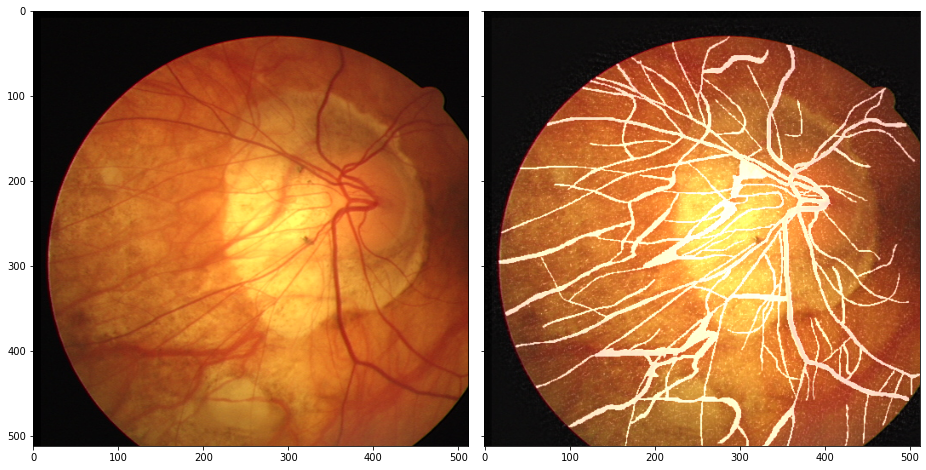

In [ ]:
#################################################################
# Mostrar resultados
#################################################################

np_img = images[2]
np_img = np_img * 255
np_img = np.uint8(np_img)
mascara = masks[2]
#cv2_imshow(np_img)
#cv2_imshow(mascara)

# Prepare the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,8), sharex = True, sharey = True)

# Load the image in the plot
axes[0].imshow(np_img)

# Prepares the mask to be superimposed on the medical image
result = np.zeros(np_img.shape)

#print(result[:,:,:].shape)
#print(mascara[:,:].shape)
result[:,:] = np_img
result[:,:] += mascara[:,:] * 0.7
result = np.minimum(result, 255).astype(np.uint8)

#Load the mask on the plot
axes[1].imshow(result)
plt.tight_layout()
plt.show()